# Préambule : installation

```bash
pip install vaderSentiment wordcloud
```

# ------------------- Charger les avis et préparer la donnée -------------------

In [2]:
import os, pandas as pd
from sqlalchemy import create_engine

PGURL  = os.getenv("SUPABASE_DB_URL")
engine = create_engine(PGURL)

reviews = pd.read_sql("""
    SELECT id,
           listing_id,
           date,
           comments
    FROM reviews
    WHERE comments IS NOT NULL
""", engine)

print(f"{len(reviews):,} avis chargés")

384,987 avis chargés


# ------------------- Calcul du sentiment (VADER) -------------------

In [6]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

def vader_score(text: str) -> float:
    return sia.polarity_scores(text)["compound"]

reviews["sentiment"] = reviews["comments"].apply(vader_score)
reviews.head()

,id,listing_id,date,comments,sentiment
0,55332,29059,2010-06-20,This apt was soooo adorable! Centrally located...,0.9606
1,59988,29059,2010-07-02,I had a wonderful stay at Maryline's lovely an...,0.9776
2,61088,29059,2010-07-05,Both my husband and I had a wonderful experien...,0.9680
3,386009,29059,2011-07-20,This was our first trip to Montreal and we had...,0.9955
4,399065,29059,2011-07-26,We stayed in Maryline's studio for a long week...,0.9759


# ------------------- Distribution globale des sentiments -------------------

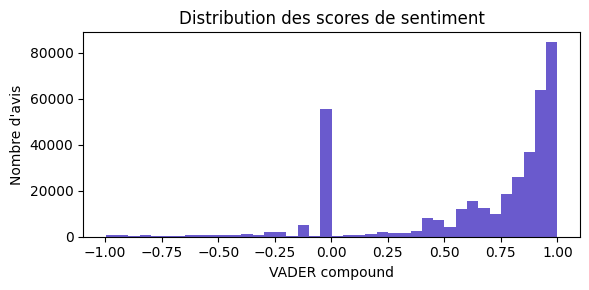

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,3))
reviews["sentiment"].plot.hist(bins=40, color="slateblue")
plt.title("Distribution des scores de sentiment")
plt.xlabel("VADER compound")
plt.ylabel("Nombre d'avis")
plt.tight_layout()
plt.show()

# ------------------- Score moyen par logement et par quartier -------------------

In [8]:
# Moyenne par logement
sent_listing = (reviews.groupby("listing_id")["sentiment"]
                          .mean()
                          .reset_index())

# Ajout du quartier
listings_neigh = pd.read_sql("SELECT id, neighbourhood FROM listings", engine)
sent_listing = sent_listing.merge(listings_neigh,
                                  left_on="listing_id",
                                  right_on="id")

# Moyenne par quartier
sent_neigh = (sent_listing.groupby("neighbourhood")["sentiment"]
                            .mean()
                            .sort_values(ascending=False)
                            .to_frame("avg_sentiment"))
sent_neigh.head()

,avg_sentiment
neighbourhood,
Kirkland,0.969600
L'Île-Bizard-Sainte-Geneviève,0.864623
Beaconsfield,0.718962
Westmount,0.690224
Montréal-Ouest,0.673656


# ------------------- Wordclouds -------------------

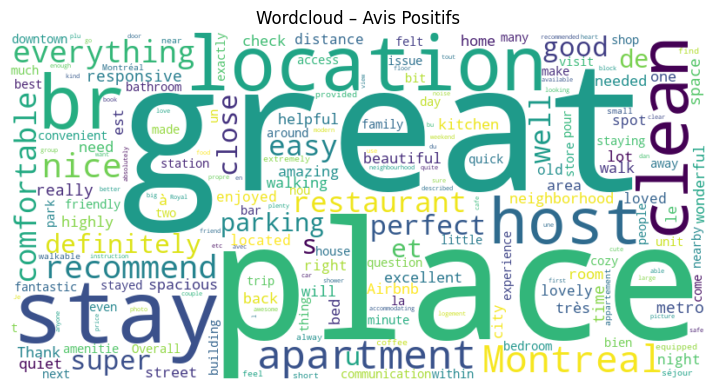

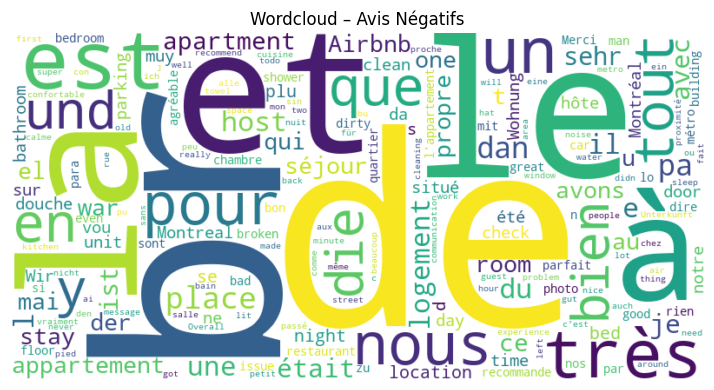

In [10]:
from wordcloud import WordCloud

positive_text = " ".join(reviews.loc[reviews["sentiment"] > 0.3, "comments"])
negative_text = " ".join(reviews.loc[reviews["sentiment"] < -0.3, "comments"])

for label, text in [("Positifs", positive_text), ("Négatifs", negative_text)]:
    wc = WordCloud(width=800, height=400,
                   background_color="white",
                   collocations=False).generate(text)
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Wordcloud – Avis {label}")
    plt.tight_layout()
    plt.show()

# ------------------- Exports pour le dashboard -------------------


In [11]:
sent_listing.to_csv("outputs/sentiment_by_listing.csv", index=False)
sent_neigh.reset_index().to_csv("outputs/sentiment_by_neigh.csv", index=False)

# ------------------- Observations Markdown -------------------

In [12]:
from IPython.display import Markdown

avg_global  = reviews["sentiment"].mean()
top_neigh   = sent_neigh.index[0]
top_score   = sent_neigh.iloc[0,0]
low_neigh   = sent_neigh.index[-1]
low_score   = sent_neigh.iloc[-1,0]

Markdown(f"""
### Insights – Sentiment des avis

- **Score moyen global** : {avg_global:.2f}  
- **Quartier le plus positif** : *{top_neigh}* (score moyen {top_score:.2f}).  
- **Quartier le moins positif** : *{low_neigh}* (score moyen {low_score:.2f}).  
- Proportion d'avis clairement positifs (> 0,05) : {(reviews['sentiment']>0.05).mean():.1%}  
- Proportion d'avis négatifs (< –0,05) : {(reviews['sentiment']<-0.05).mean():.1%}
""")


### Insights – Sentiment des avis

- **Score moyen global** : 0.64  
- **Quartier le plus positif** : *Kirkland* (score moyen 0.97).  
- **Quartier le moins positif** : *Montréal-Nord* (score moyen 0.21).  
- Proportion d'avis clairement positifs (> 0,05) : 80.5%  
- Proportion d'avis négatifs (< –0,05) : 5.0%
